In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.utils import shuffle
from scipy.spatial.distance import euclidean, cityblock, chebyshev
from scipy.special import softmax

In [ ]:
specter = np.load('drive/MyDrive/ailr/7.npy')
mask = np.load('drive/MyDrive/ailr/7_mask.npy')

In [ ]:
specter.shape, mask.shape

((512, 512, 237), (512, 512))

In [ ]:
b_index = 10
g_index = 16
r_index = 35

b = np.expand_dims(specter[..., b_index], axis=2)
g = np.expand_dims(specter[..., g_index], axis=2)
r = np.expand_dims(specter[..., r_index], axis=2)

rgb_specter_representation = np.concatenate((r, g, b), axis=2)
rgb_specter_representation.shape

(512, 512, 3)

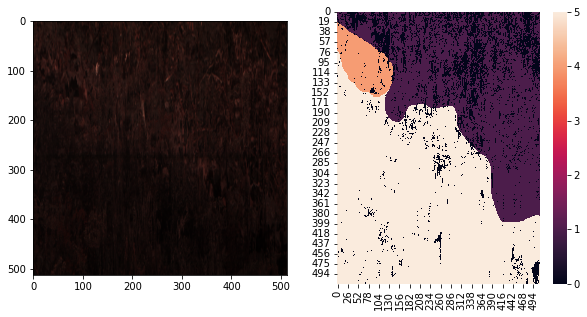

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(rgb_specter_representation)
sns.heatmap(mask, ax=ax2)

In [ ]:
def dist(x, y):
    """
    Calculates Euclidean distance
    """
    diff = x - y
    dist_2 = np.sum(diff * diff, axis=-1)
    return np.sqrt(dist_2)


def mandist(x, y):
    """
    Calculates manhattan distance
    """
    return np.linalg.norm(x - y, axis=1, ord=1)

def chebdist(x, y):
    """
    Calculates chebyshev distance
    """
    return np.linalg.norm(x - y, axis=1, ord=np.inf)

In [ ]:
def k_means(X, K, distfunc, max_iter=20):
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Метки
    L = np.zeros(N)
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    M_prev = M.copy()
    for i in range(max_iter):
        dists = []
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            #arr = []
            #for x in X:
            #    arr.append(distfunc(x, M[k]))
            dists += [distfunc(X, M[k]).reshape(-1, 1)]
            #dists += [np.array(arr).reshape(-1, 1)]
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        # Найдем ближайший кластер для каждой точки (шаг 2)
        L = np.argmin(dists, axis=1)
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = X[L==k].mean(axis=0)
            
        # Проверим условие сходимости
        if np.allclose(M, M_prev):
            print(f'KMeans converged on {i}th iteration')
            break
        else:
            M_prev = M.copy()
    
    return M, L

In [ ]:
def cluster_resp(distances):
    d_exp = np.exp(-distances)
    sum = np.sum(d_exp, axis=1, keepdims=True)
    return d_exp - sum 

In [ ]:
def loss(X, M, R):
    loss = 0
    for k in range(len(M)):
        d = dist(X, M[k])
        loss += np.sum(R[:,k] * (d * d))
    return loss

In [ ]:
def soft_k_means(X, K, distfunc, max_iter=20):
    # N - number of samples, D - dimensionality (number of features)
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Responsibility matrix.
    # R[i, j] = probability that point `i` belongs to cluster `j` 
    # or responsibility of the cluster `j` for the point `i`.
    # Матрица принадлежности.
    # R[i, j] = вероятность того что `i` точка принадлежит кластеру `j`
    # или пренадлежность кластера `j` точке `i`
    R = np.zeros((N, K))
    # Cluster centers
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Loss array
    # Массив значений ошибок
    losses = []
    
    # Randomly initialize the centers (step 1)
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    for i in range(max_iter):
        dists = []
        # Calculate distances from each point to each cluster.
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            dists += [distfunc(X, M[k]).reshape(-1, 1)]
        # dists has shape (K, N, 1)
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        
        # Calculate cluster responsibilities (step 2)
        # Вычислим значения принадлежностей точек кластерам (шаг 2)
        R = softmax(-dists)
        #R = cluster_resp(dists)
        # Recalculate cluster centers (step 3)
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
            
        losses.append(loss(X, M, R))
            
        # Check convergence condition
        # Проверим условие сходимости
        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) < 1e-6:
            break
    np.nan_to_num(R, nan = 1e9)
    np.nan_to_num(M, nan = 1e9)
    np.nan_to_num(losses, nan = 1e9)
    return M, R, losses

In [ ]:
height = rgb_specter_representation.shape[0]
width = rgb_specter_representation.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)
from sklearn.model_selection import train_test_split
train_indices = ordered_positions
test_indices = []
#train_indices, test_indices = train_test_split(ordered_positions, train_size=0.05, shuffle=True)

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

In [ ]:
for idx in train_indices:
    x_train.append(specter[idx[0], idx[1], ::])
    y_train.append(mask[idx[0], idx[1]])    
    
for idx in test_indices:
    x_test.append(specter[idx[0], idx[1], ::])
    y_test.append(mask[idx[0], idx[1]])    
    
x_train = np.array(x_train, copy=False)
y_train = np.array(y_train, copy=False)
x_test = np.array(x_test, copy=False)
y_test = np.array(y_test, copy=False)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((262144, 237), (262144,), (0,), (0,))

In [ ]:
def metrics_purity(class_labels, cluster_labels):
    """
    Compute the purity metric for evaluation of clustering.
    
    Parameters
    ----------
    class_labels : ndarray
        Contains true labels. Shape [n_points].
    cluster_labels : ndarray
        Contains clustering labels. Shape [n_points].
        
    Returns
    -------
    float
        Purity metric 
    """
    
    c_m = contingency_matrix(class_labels, cluster_labels)
    return np.sum(np.amax(c_m, axis=0)) / np.sum(c_m)


In [ ]:
# Internal evaluation
def metrics_davies_bouldin(X, cluster_labels, distance=euclidean):
    """
    Computes Davies Bouldin Index.
    
    Parameters
    ----------
    X : ndarray
        Data points. Shape [n_points, num_features].
    cluster_labels : ndarray
        Contains clustering labels. Shape [n_points].
    distance : function
        Python function with API: distance(vector_a, vector_b) -> float.
    
    Returns
    -------
    float
        Davies Bouldin Index.
    """
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / distance(centroids[i], centroids[j]))

    return(np.max(db) / n_cluster)

In [ ]:
def plot(plotx, plotPurity, plotDBI, name):
    barlist = plt.bar(plotx, plotPurity,  alpha=0.5, label='Purity', color="blue")
    mx = max(plotPurity)
    idx = plotPurity.index(mx)
    barlist[idx].set_color('yellow')

    barlist = plt.bar(plotx, plotDBI, alpha=0.5, label='DBI', color = "red")
    plt.legend(loc='upper left')
    mx = min(plotDBI)
    idx = plotDBI.index(mx)
    barlist[idx].set_color('green')
    
    plt.title(name)
    plt.show()

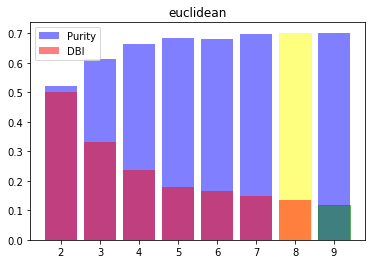

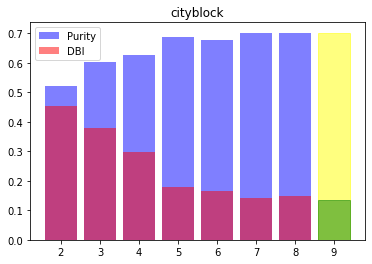

KMeans converged on 17th iteration
KMeans converged on 19th iteration


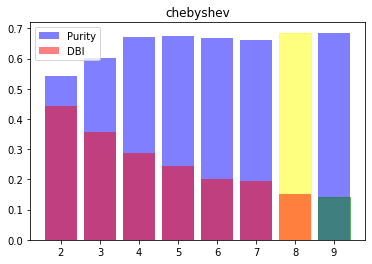

In [ ]:
purityBest = None
purityBestVal = 0
dbiBest = None
dbiBestVal = 1e9


mydist = [dist, mandist, chebdist]
dists = [euclidean, cityblock, chebyshev]
for dst in range(3):
    plotx = []
    plotPurity = []
    plotDBI = []
    for i in range(2, 10):
        plotx.append(i)
        m, l = k_means(x_train, i, mydist[dst])
        pur = metrics_purity(y_train, l)
        dbi = metrics_davies_bouldin(x_train, l, dists[dst])
        plotPurity.append(pur)
        plotDBI.append(dbi)

        if pur > purityBestVal:
            purityBestVal = pur
            purityBest = l
        if dbi < dbiBestVal :
            dbiBestVal = dbi
            dbiBest = l

    plot(plotx, plotPurity, plotDBI, dists[dst].__name__)

Text(0.5, 1.0, 'best Predictions for DBI')

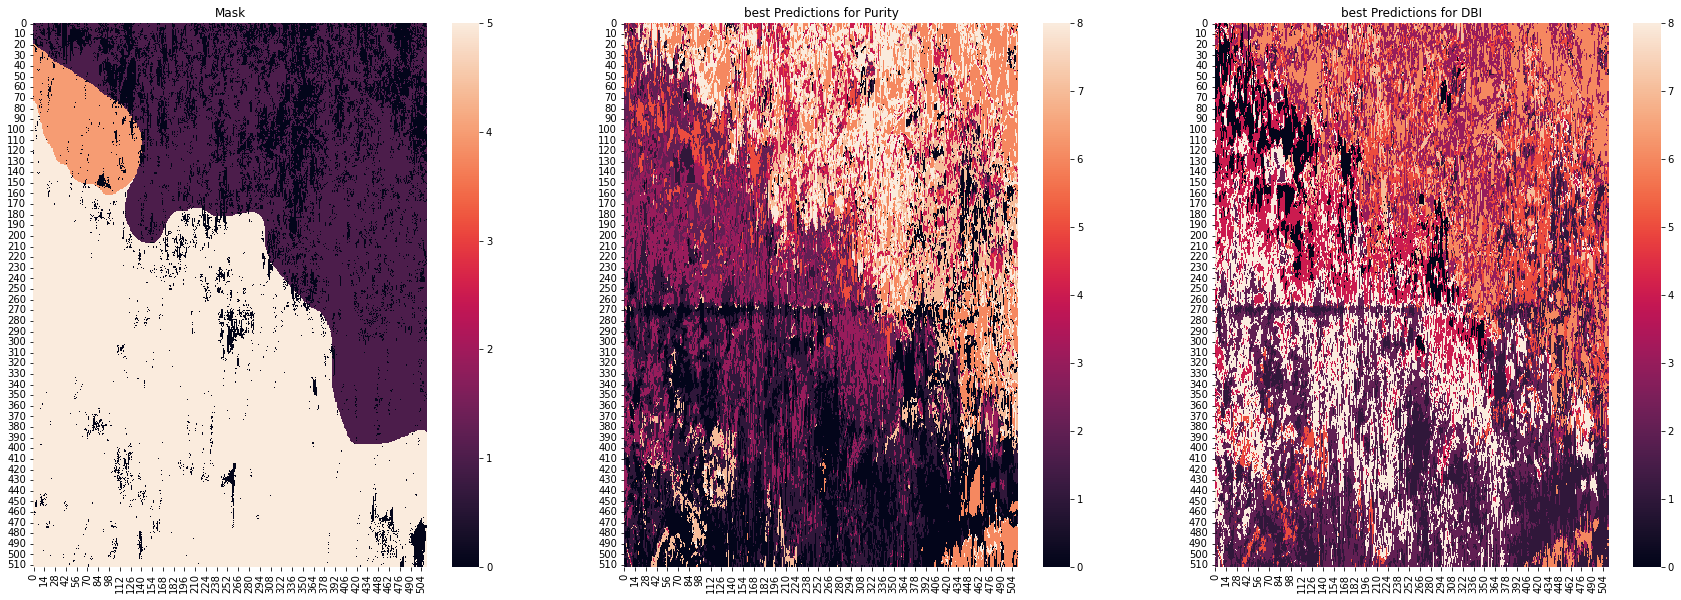

In [ ]:
predictions_map_purity = np.zeros_like(mask)
for (y, x), pred in zip(train_indices, purityBest):
    predictions_map_purity [y, x] = pred

predictions_map_dbi = np.zeros_like(mask)
for (y, x), pred in zip(train_indices, dbiBest):
    predictions_map_dbi[y, x] = pred
    
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map_purity , ax=ax2)
sns.heatmap(predictions_map_dbi, ax=ax3)
ax1.set_title('Mask')
ax2.set_title('best Predictions for Purity')
ax3.set_title('best Predictions for DBI')

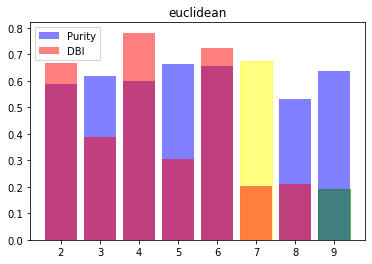

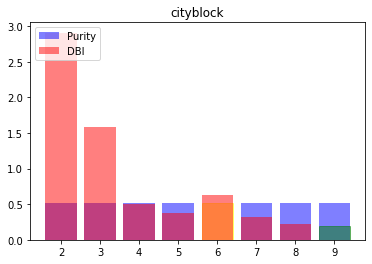

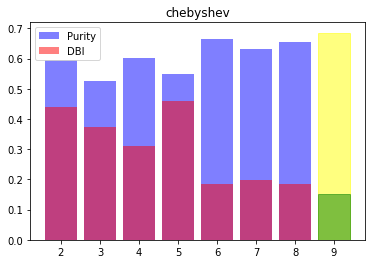

In [ ]:
mydist = [dist, mandist, chebdist]
dists = [euclidean, cityblock, chebyshev]

purityBest = l
purityBestVal = 0
dbiBest = l
dbiBestVal = 1e9

for dst in range(0,3):
    plotx = []
    plotPurity = []
    plotDBI = []
    for i in range(2, 10):
        plotx.append(i)
        m, r, losses = soft_k_means(x_train, i, mydist[dst])
        l = np.argmax(r, axis=1)
        pur = metrics_purity(y_train, l)
        dbi = metrics_davies_bouldin(x_train, l, dists[dst])
        plotPurity.append(pur)
        plotDBI.append(dbi)

        if pur > purityBestVal:
            purityBestVal = pur
            purityBest = l
        if dbi < dbiBestVal :
            dbiBestVal  = dbi
            dbiBest = l
    plot(plotx, plotPurity, plotDBI, dists[dst].__name__)

Text(0.5, 1.0, 'best predictions for DBI')

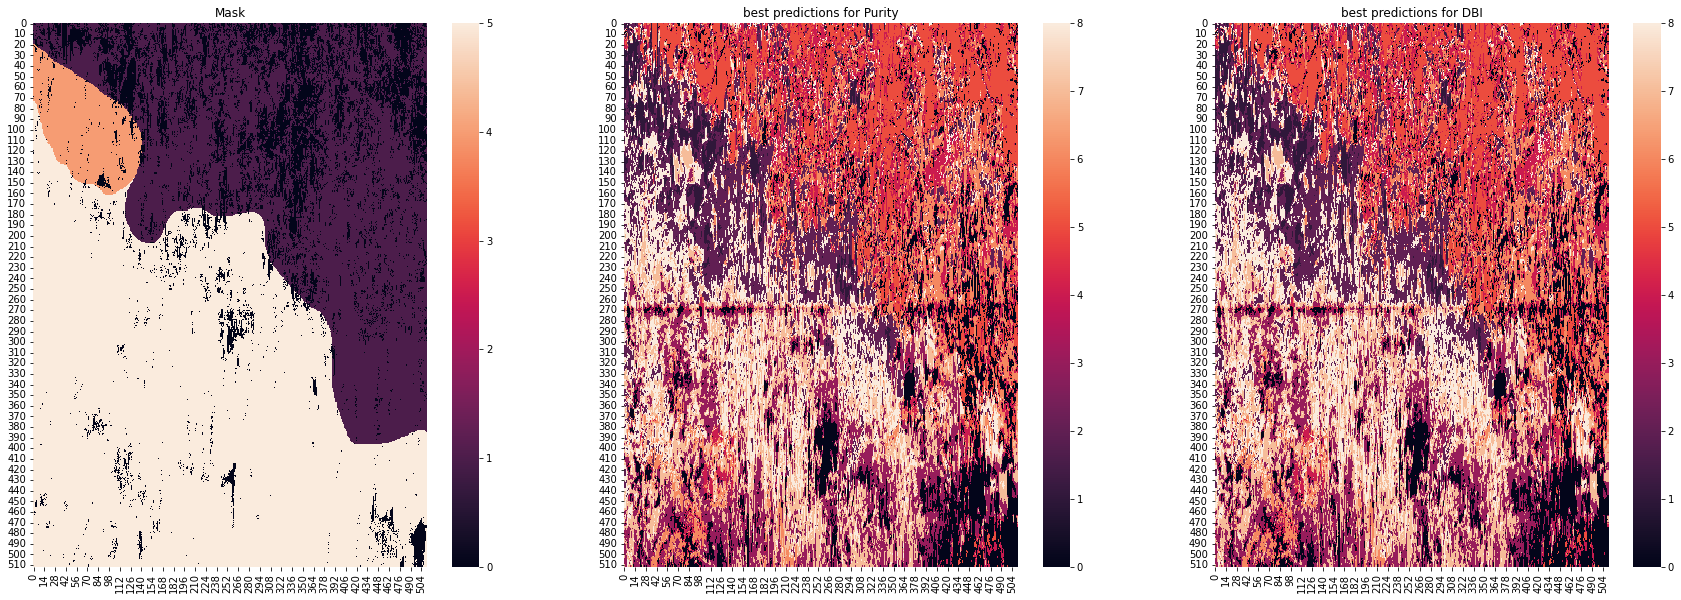

In [ ]:
predictions_map_purity = np.zeros_like(mask)
for (y, x), pred in zip(train_indices, purityBest):
    predictions_map_purity [y, x] = pred

predictions_map_dbi = np.zeros_like(mask)
for (y, x), pred in zip(train_indices, dbiBest):
    predictions_map_dbi[y, x] = pred
    
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map_purity , ax=ax2)
sns.heatmap(predictions_map_dbi, ax=ax3)
ax1.set_title('Mask')
ax2.set_title('best predictions for Purity')
ax3.set_title('best predictions for DBI')